# Quantitative analysis of HISTALP commitment run
This notebooks computes equilibrium values, e-folding time scales, and more from the data of the HISTALP commitment experiment. The values are used in Chapter 3, Section 3: **Regional runs with all Alpine glaciers**.

In [1]:
# import section
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [2]:
def read_dataset(path):
    # read dataset
    ds = xr.load_dataset(path)
    # sort by temperature bias
    ds = ds.sortby('temp_bias')
    # cast normalized dimension from int to bool
    ds['normalized'] = [bool(norm) for norm in ds.normalized]

    return ds

In [3]:
# read dataset
path = '/Users/oberrauch/work/master/data/cluster_output/histalp_commitment/eq_runs.nc'
ds = read_dataset(path)

**Final volume of constant mass balance scenario**

In [4]:
# get table with final values of volume for constant mb model
var = 'volume'
mb_m = 'constant'
data = list()

for m in ds.model.values:
    for b in ds.temp_bias.values:
        # select last volume entry from dataset by model and temperature bias
        ds_abs = ds.sel(mb_model=mb_m, model=m, normalized=False, temp_bias=b, rgi_id='sum').isel(time=1000)['volume']
        ds_norm = ds.sel(mb_model=mb_m, model=m, normalized=True, temp_bias=b, rgi_id='sum').isel(time=1000)['volume']
        data.append([np.round(ds_abs.values/1e9), ds_norm.values-1])
        
table = pd.DataFrame(data,
                     index=pd.MultiIndex.from_tuples(list(zip(np.repeat(['vas', 'flowline'], 3),
                                                              np.tile([-.5, 0, .5], 2)))),
                     columns=pd.MultiIndex.from_tuples(list(zip(np.repeat(['volume'], 2),
                                                                np.tile(['abs', 'norm'], 1)))),)
table

volume          
                 abs      norm
vas      -0.5  156.0  0.198523
          0.0  130.0  0.000024
          0.5  109.0 -0.166642
flowline -0.5  259.0  0.584518
          0.0  169.0  0.034130
          0.5   92.0 -0.435427

**Difference between constant and random mass balance models in the last 200 years**

In [5]:
# get table with min/mean/max differences in volume between mb models
var = 'volume'
data = list()
for m in ds.model.values:
    for b in ds.temp_bias.values:
        # select volume from dataset by model and temperature bias
        ds_abs = ds.sel(model=m, normalized=False, temp_bias=b, rgi_id='sum').isel(time=slice(800,1000))[var]
        ds_norm = ds.sel(model=m, normalized=True, temp_bias=b, rgi_id='sum').isel(time=slice(800,1000))[var]
        # compute absolute differences between the mass balance models
        diff_abs = abs(ds_abs.diff(dim='mb_model').values)
        diff_norm = abs(ds_norm.diff(dim='mb_model').values)
        data.append([diff_abs.min(), diff_norm.min(),
                     diff_abs.mean(), diff_norm.mean(),
                     diff_abs.max(), diff_norm.max()])
        

table = pd.DataFrame(data,
                     index=pd.MultiIndex.from_tuples(list(zip(np.repeat(['vas', 'flowline'], 3),
                                                              np.tile([-.5, 0, .5], 2)))),
                     columns=pd.MultiIndex.from_tuples(list(zip(np.repeat(['min', 'mean', 'max'], 2),
                                                                np.tile(['abs', 'norm'], 3)))),)
table

min                    mean                     max  \
                        abs      norm           abs      norm           abs   
vas      -0.5  7.101802e+06  0.000044  8.358657e+08  0.006403  1.864898e+09   
          0.0  1.929007e+07  0.000156  7.542893e+08  0.005778  1.681002e+09   
          0.5  4.591182e+06  0.000042  6.679529e+08  0.005117  1.480892e+09   
flowline -0.5  1.500306e+09  0.008765  2.761250e+09  0.016478  4.298013e+09   
          0.0  3.295673e+09  0.020146  4.572250e+09  0.027951  5.807215e+09   
          0.5  1.356088e+08  0.000829  1.527202e+09  0.009337  2.812994e+09   

                         
                   norm  
vas      -0.5  0.014282  
          0.0  0.012874  
          0.5  0.011342  
flowline -0.5  0.025878  
          0.0  0.035501  
          0.5  0.017197

Yearly relative differences

In [15]:
# get table with min/mean/max differences in volume between mb models
var = 'volume'
data = list()
for m in ds.model.values:
    for b in ds.temp_bias.values:
        # select volume from dataset by model and temperature bias
        ds_abs = ds.sel(model=m, normalized=False, temp_bias=b, rgi_id='sum').isel(time=slice(800,1000))[var]
        ds_norm = ds.sel(model=m, normalized=True, temp_bias=b, rgi_id='sum').isel(time=slice(800,1000))[var]
        # compute absolute differences between the mass balance models
        diff_abs = abs(ds_abs.diff(dim='mb_model').values)
        mean_abs = abs(ds_abs.mean(dim='mb_model').values)
        rel_diff = diff_abs/mean_abs

        data.append([f'{rel_diff.min()*100:.1f}', f'{rel_diff.min()*100:.1f}',
                     f'{rel_diff.mean()*100:.1f}'])

In [18]:
table = pd.DataFrame(np.array(data),
                     index=pd.MultiIndex.from_tuples(list(zip(np.repeat(['vas', 'flowline'], 3),
                                                              np.tile([-.5, 0, .5], 2)))),
                     columns=['min', 'mean', 'max'])
table

min mean  max
vas      -0.5  0.0  0.0  0.5
          0.0  0.0  0.0  0.6
          0.5  0.0  0.0  0.6
flowline -0.5  0.6  0.6  1.1
          0.0  2.0  2.0  2.7
          0.5  0.1  0.1  1.7

**Response times $\tau$**

In [46]:
variables = ['volume', 'area', 'length',]
temp_biases = [-0.5, +0.5]
data = list()
for var in variables:
    data_ = list()
    for m in ds.model.values:
        data__ = list()
        for b in temp_biases:
            ds_sel = ds.sel(mb_model='constant', model=m, temp_bias=b, rgi_id='sum')
            vol = ds_sel.sel(normalized=1)[var]
            vol_eq = vol.isel(time=slice(800,1000)).mean()
            vol_eq_dif = np.abs(vol_eq - vol.isel(time=0))
            vol_dif = np.abs(vol_eq - vol)
            data__.append(int(vol.where(vol_dif < vol_eq_dif*np.exp(-1), drop=True).isel(time=0)['time'].values))
        data_.extend(data__)
    data.append(data_)
    
tau = pd.DataFrame(data, columns=pd.MultiIndex.from_tuples(list(zip(np.repeat(ds.model.values, 2),
                                                                    np.tile(temp_biases, 2)))),
                   index=variables)
tau

vas        fl     
       -0.5  0.5 -0.5  0.5
volume   23   20  125   79
area     32   27  151  107
length   35   31  161   90

**Look at volume increase for equilibrium climate**

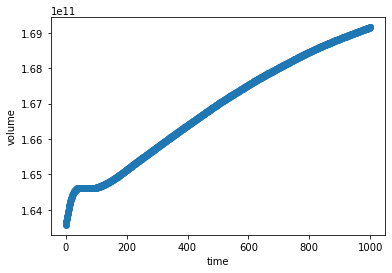

In [42]:
ds_sel = ds.sel(mb_model='constant', model='fl', normalized=False, temp_bias=0, rgi_id='sum')
volume_sel = ds_sel.volume
xr.plot.scatter(ds_sel, 'time', 'volume')

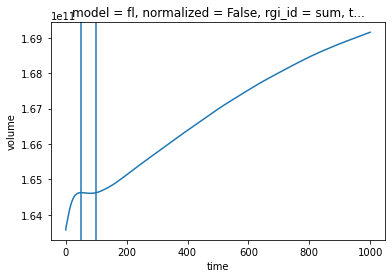

In [22]:
volume_sel.plot()
plt.axvline(50)
plt.axvline(100)

In [45]:
np.diff(volume_sel.sel(time=[0, 1000]).values)

array([5.58266302e+09])

In [34]:
from sklearn.linear_model import LinearRegression
y = volume_sel.sel(time=slice(100, None)).values
x = np.arange(y.size)
mod = LinearRegression().fit(x.reshape((-1,1)), y)
mod.coef_[0]*100/1e9

0.5263339948059683

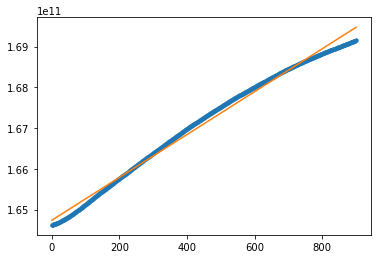

In [35]:
y = volume_sel.sel(time=slice(100, None)).values
plt.plot(y, ls='None', marker='.')
plt.plot(x*mod.coef_[0]+mod.intercept_)

### Quantitative analysis for Hintereisferner

In [61]:
# read dataset
path = '/Users/oberrauch/work/master/data/cluster_output/single_glaciers/eq_runs.nc'
ds = read_dataset(path)
# select Hintereisferner
ds = ds.sel(rgi_id='RGI60-11.00897')

**Correlation between vas model and flowline model under random climate**

In [73]:
# get 
variables = ['volume', 'area', 'length',]
mb_m = 'random'
n = True
r_data = list()
p_data = list()
for var in variables:
    r_data_ = list()
    p_data_ = list()
    for b in ds.temp_bias.values:
        # select volume from dataset by temperature bias and geometric variable
        time_slice = slice(0,1000)
        ds_sel = ds.sel(mb_model=mb_m, normalized=n, temp_bias=b).isel(time=time_slice)[var]
        # compute correlation and add to container
        r, p = pearsonr(ds_sel.sel(model='vas'), ds_sel.sel(model='fl'))
        r_data_.append(r)
        p_data_.append(p)
    r_data.append(r_data_)
    p_data.append(p_data_)
    
df_r = pd.DataFrame(r_data, index=variables, columns=ds.temp_bias.values)
df_p = pd.DataFrame(p_data, index=variables, columns=ds.temp_bias.values)

Compute and show range of $r$- and $p$-values

In [74]:
# Pearson correlation coefficient
df_r

,-0.5,0.0,0.5
volume,0.351847,0.583906,0.406146
area,0.336697,0.475724,0.350043
length,0.529037,0.520428,0.582786


In [75]:
print('Minimum correlation:', df_r.min().min())
print('Maximum correlation:', df_r.max().max())

Minimum correlation: 0.3366973442986697
Maximum correlation: 0.5839061262518078


In [76]:
# two-sided p value
df_p

,-0.5,0.0,0.5
volume,1.632241e-30,1.890370e-92,5.305373e-41
area,6.256902e-28,1.310603e-57,3.372926e-30
length,3.330477e-73,1.705035e-70,5.087519e-92


In [77]:
print('Minimum p-value:', df_p.min().min())
print('Maximum p-value:', df_p.max().max())

Minimum p-value: 1.8903700076970558e-92
Maximum p-value: 6.256901936179863e-28


Create scatter plots

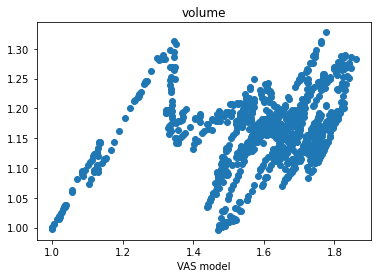

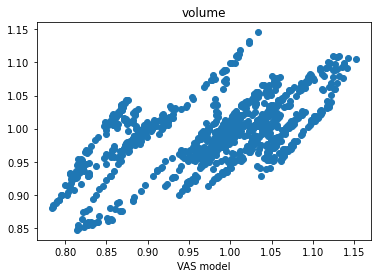

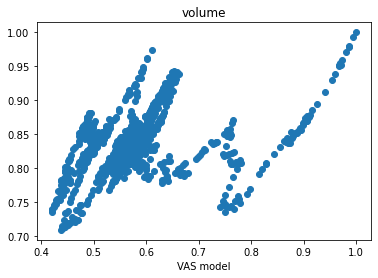

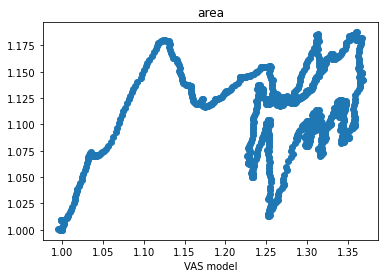

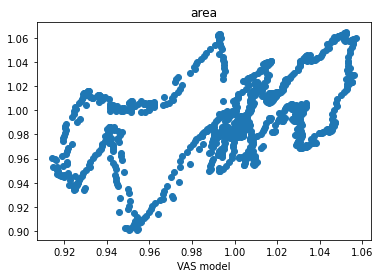

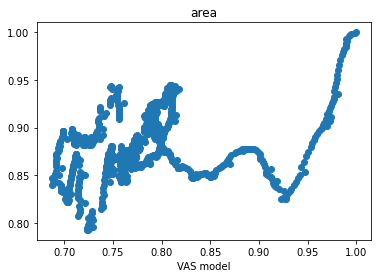

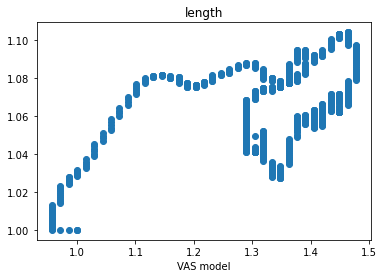

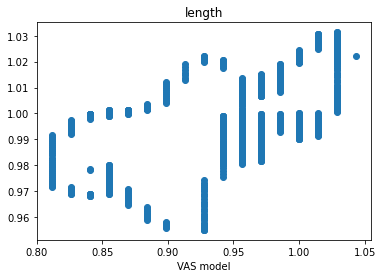

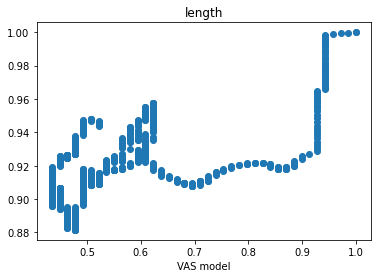

In [29]:
# get 
variables = ['volume', 'area', 'length',]
mb_m = 'random'
n = True
data = list()
for var in variables:
    for b in ds.temp_bias.values:
        # select volume from dataset by temperature bias and geometric variable
        time_slice = slice(0,1000)
        ds_sel = ds.sel(mb_model=mb_m, normalized=n, temp_bias=b).isel(time=time_slice)[var]
        plt.figure()
        plt.scatter(ds_sel.sel(model='fl'), ds_sel.sel(model='vas'))
        plt.title(var)
        plt.xlabel('Flowline model')
        plt.xlabel('VAS model')

**Response times $\tau$**

In [78]:
variables = ['volume', 'area', 'length',]
temp_biases = [-0.5, +0.5]
data = list()
for var in variables:
    data_ = list()
    for m in ds.model.values:
        data__ = list()
        for b in temp_biases:
            ds_sel = ds.sel(mb_model='constant', model=m, temp_bias=b)
            vol = ds_sel.sel(normalized=1)[var]
            vol_eq = vol.isel(time=slice(800,1000)).mean()
            vol_eq_dif = np.abs(vol_eq - vol.isel(time=0))
            vol_dif = np.abs(vol_eq - vol)
            data__.append(int(vol.where(vol_dif < vol_eq_dif*np.exp(-1), drop=True).isel(time=0)['time'].values))
        data_.extend(data__)
    data.append(data_)
    
tau = pd.DataFrame(data, columns=pd.MultiIndex.from_tuples(list(zip(np.repeat(ds.model.values, 2),
                                                                    np.tile(temp_biases, 2)))),
                   index=variables)
tau

vas        fl     
       -0.5  0.5 -0.5  0.5
volume   24   22  142   80
area     36   33  160  111
length   55   52  184  118

In [95]:
def rel_dif(a,b):
    """Compute relative difference between a and b"""
    return abs(a-b)/((a+b)/2)

# test
i = 4.89
p = 5.26
n = 4.52
assert(rel_dif(abs(i-n),abs(i-p)) == 0)

In [97]:
# compute relative difference in tau between pos and neg temperature bias
for var, row in tau.iterrows():
    rd = rel_dif(row['vas'][-0.5], row['vas'][+0.5])
    print('VAS {}: {:.2f}'.format(var, rd))
    rd = rel_dif(row['fl'][-0.5], row['fl'][+0.5])
    print('FL {}: {:.2f}'.format(var, rd))

VAS volume: 0.09
FL volume: 0.56
VAS area: 0.09
FL area: 0.36
VAS length: 0.06
FL length: 0.44


**Equilibrium values**

Compute fluctuations of the equilibrium value over the last 200 years of the simulation. This is done by computing the  relative difference (see above) between minimum and maximum value in that period. The table shows the results in percent.

In [114]:
var = ''
data = list()
variables = ['volume', 'area', 'length',]
models = ['vas', 'fl']
temp_biases = [+0.5, -0.5]
for var in variables:
    data_ = list()
    for m in models:
        data__ = list()
        for b in temp_biases:
            ds_sel = ds.sel(mb_model='constant', model=m, temp_bias=b, normalized=True).isel(time=slice(-200, None))[var]
            
            rd = rel_dif(min(ds_sel).values, max(ds_sel).values)
            data__.append(f'{rd*100:.2f}%')
        data_.extend(data__)
    data.append(data_)
    
columns = pd.MultiIndex.from_tuples(list(zip(np.tile(temp_biases, 2),
                                             np.repeat(models, 2))))

eq_fluctuations = pd.DataFrame(data, index=variables, columns=columns).T.sort_index(level=0, sort_remaining=False, ascending=True)
eq_fluctuations.T

-0.5           0.5       
          vas     fl    vas     fl
volume  0.00%  0.02%  0.00%  0.00%
area    0.00%  0.03%  0.00%  0.01%
length  0.00%  0.00%  0.00%  0.00%

Compute new equilibrium values for runs with temperature perturbation. Table shows absolute and relative values.

In [100]:
var = ''
data = list()
variables = ['volume', 'area', 'length',]
models = ['vas', 'fl']
temp_biases = [+0.5, -0.5]
for var in variables:
    data_ = list()
    for m in models:
        data__ = list()
        for b in temp_biases:
            ds_sel = ds.sel(mb_model='constant', model=m, temp_bias=b)
            avg_abs = ds_sel.sel(normalized=False, time=999)[var].values
            avg_norm = ds_sel.sel(normalized=True, time=999)[var].values
            data__.append('{:.2e} ({:.0f}%)'.format(avg_abs, avg_norm*1e2))
        data_.extend(data__)
    data.append(data_)
    
columns = pd.MultiIndex.from_tuples(list(zip(np.tile(temp_biases, 2),
                                             np.repeat(models, 2))))

eq_values = pd.DataFrame(data, index=variables, columns=columns).T.sort_index(level=0, sort_remaining=False, ascending=True)
eq_values.T

-0.5                              0.5                
                    vas               fl             vas              fl
volume  6.95e+08 (117%)  1.38e+09 (172%)  5.04e+08 (85%)  4.62e+08 (58%)
area    8.98e+06 (112%)  1.06e+07 (133%)  7.12e+06 (89%)  6.16e+06 (77%)
length  5.25e+03 (107%)  9.80e+03 (142%)  4.54e+03 (93%)  3.80e+03 (55%)

Compute maximum year-to-year length variation estimated by the VAS model

{'whiskers': [<matplotlib.lines.Line2D at 0x13b1a6b70>,
 'caps': [<matplotlib.lines.Line2D at 0x13b1b0160>,
 'boxes': [<matplotlib.lines.Line2D at 0x13b1a6908>],
 'medians': [<matplotlib.lines.Line2D at 0x13b1b0710>],
 'fliers': [<matplotlib.lines.Line2D at 0x13b1b09e8>],
 'means': []}

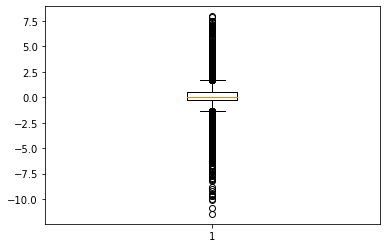

In [147]:
vas_length = ds.sel(model='vas', normalized=False).length
plt.boxplot(vas_length.diff(dim='time').values.flatten())

In [150]:
pd.DataFrame(vas_length.diff(dim='time').values.flatten()).describe()

,0
count,6.000000e+03
mean,3.925596e-02
std,1.876294e+00
min,-1.146011e+01
25%,-2.223657e-01
50%,2.799470e-08
75%,5.305154e-01
max,7.971097e+00


In [142]:
max_dl = abs(vas_length.diff(dim='time').values).flatten().max()
print(f'Maximum year-to-year length change: {max_dl:.0f} m')

Maximum year-to-year length change: 11 m


Get HEF length records and take a look...

In [131]:
from oggm import utils

<AxesSubplot:>

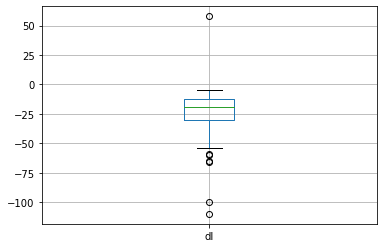

In [141]:
hef_leclercq = pd.read_csv(utils.get_demo_file('hef_lengths.csv'), index_col=0)
hef_dl = hef_leclercq.diff()[1:]
hef_dl.loc[1939:].boxplot()

In [151]:
hef_dl.loc[1939:].describe()

,dl
count,65.000000
mean,-24.676923
std,23.499407
min,-110.000000
25%,-30.000000
50%,-19.000000
75%,-12.000000
max,58.000000


Legacy code block... can be ignored!

In [79]:
data = list()
variables = ['length', 'area', 'volume']
temp_biases = [-0.5, +0.5]
for var in variables:
    data_ = list()
    for m in ds.model.values:
        data__ = list()
        for b in temp_biases:
            ds_sel = ds.sel(mb_model='constant', model=m, temp_bias=b)
            avg_abs = ds_sel.sel(normalized=False, time=1000)[var].mean().values
            avg_norm = ds_sel.sel(normalized=True, time=1000)[var].mean().values
            data__.extend([avg_abs, avg_norm])
        data_.extend(data__)
    data.append(data_)
    
columns = pd.MultiIndex.from_tuples(list(zip(np.repeat(ds.model.values, 4),
                                             np.tile(np.repeat(temp_biases, 2), 2),
                                             np.tile(['abs', 'norm'], 4))))

pd.DataFrame(data, index=variables, columns=columns)

vas                                          \
                     -0.5                                     0.5   
                      abs                norm                 abs   
length  5246.763483635936  1.0719413014307444   4536.313119728504   
area    8980768.567467334   1.117567019346358   7115608.018185488   
volume   694767446.092732  1.1651348504414136  504457846.66868895   

                                            fl                      \
                                          -0.5                       
                      norm                 abs                norm   
length  0.9267925654406237              9800.0  1.4202898550724639   
area    0.8854664034576267  10639431.256430216  1.3287092480264158   
volume   0.845982955934108  1378865155.8170373  1.7234213227964805   

                                               
                      0.5                      
                      abs                norm  
length             3800.0  0.5507246376811594  
area    6158349.376002476  0.7690877050901378  
volume  461545414.4412079  0.5768781706689696

**Initial values**

Compute and show the initial values.

800074327.49
8007343.42
6900.00
596297884.17
8036000.00
4894.64


(0.0, 10.0)

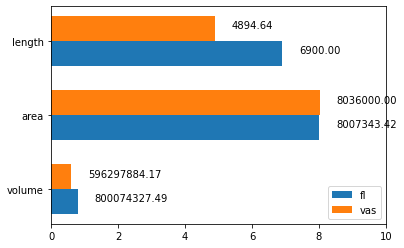

In [116]:
model = 'vas', 'flowline'
for i, model in enumerate(models[::-1]):
    ds_plot = ds.sel(normalized=False, time=0, mb_model='constant', temp_bias=0, model=model)
    x = np.array([0,1.5,3])+0.25+i*0.5
    values = ds_plot.volume, ds_plot.area, ds_plot.length
    height = ds_plot.volume/1e9, ds_plot.area/1e6, ds_plot.length/1e3
    plt.barh(x, height, label=model, height=0.5)

    for x_, y, v in zip(x, height, values):
        plt.text(y + 0.5, x_, '{:.2f}'.format(v.values), rotation=0)
        print('{:.2f}'.format(v.values))
    
plt.legend(loc=4)
plt.yticks([0.5, 2, 3.5], variables)
plt.xlim([0, 10])

([<matplotlib.axis.XTick at 0x13b4712b0>,
 [Text(0.5, 0, 'vas'), Text(3.5, 0, 'flowline')])

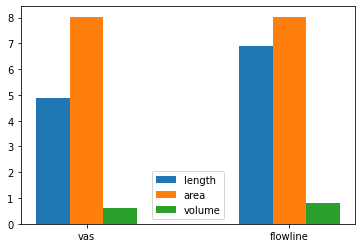

In [86]:
for i, var in enumerate(variables[::-1]):
    ds_plot = ds.sel(normalized=False, time=0, mb_model='constant', temp_bias=0)
    x = np.array([0,3])
    plt.bar(x+(i*0.5), ds_plot[var]/10**(3*(i+1)), label='{}'.format(var), width=0.5)

plt.legend()
plt.xticks([0.5, 3.5], ['vas', 'flowline'])

In [87]:
ds_plot

<xarray.Dataset>
Dimensions:         (model: 2)
Coordinates:
    hydro_month     int64 1
    calendar_year   int64 -1
    calendar_month  int64 10
    hydro_year      int64 0
  * model           (model) object 'vas' 'fl'
    time            float64 0.0
    normalized      bool False
    rgi_id          <U14 'RGI60-11.00897'
    temp_bias       float64 0.0
    mb_model        <U8 'constant'
Data variables:
    volume          (model) float64 5.963e+08 8.001e+08
    area            (model) float64 8.036e+06 8.007e+06
    length          (model) float64 4.895e+03 6.9e+03
    ela             (model) float64 0.0 3.017e+03
Attributes:
    description:    OGGM model output
    oggm_version:   1.3.2.dev113+g17c2289
    calendar:       365-day no leap
    creation_date:  2020-11-16 13:55:44

In [ ]:
    x = np.array([0,2,4])
    plt.bar(x+(i*0.5), ds_plot/10**(3*(i+1)), label='{}'.format(var), width=0.5)



In [615]:
596297884.17/(4894.64**2*1.4179698506016887)

17.553137769257216

In [609]:
ds_corr = ds.sel(model='vas', mb_model='random', normalized=False, time=slice(0,100)).volume
xr.corr(ds_corr.sel(temp_bias=+.5), ds_corr.sel(temp_bias=-.5))

<xarray.DataArray 'volume' ()>
array(-0.69395365)
Coordinates:
    model       <U3 'vas'
    normalized  bool False
    rgi_id      <U14 'RGI60-11.00897'
    mb_model    <U6 'random'

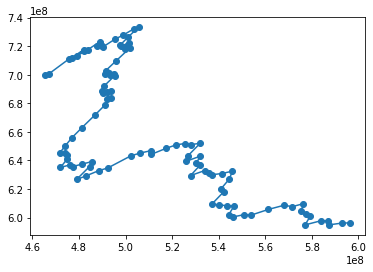

In [610]:
plt.plot(ds_corr.sel(temp_bias=+.5), ds_corr.sel(temp_bias=-.5), marker='o')

In [588]:
1.4179698506016887 * 8

count    1000.000000
mean       24.700000
std        87.450315
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       900.000000
Name: length, dtype: float64